# Project: Wrangling and Analyze Data

In [66]:
import pandas as pd
import tweepy
from tweepy import OAuthHandler
import numpy as np
import seaborn as sns
import requests
import json
from timeit import default_timer as timer
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [2]:
folder = 'weRateDogs'
if not os.path.exists(folder):
    os.makedirs(folder)
url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(os.path.join(folder,url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)
df_twitter = pd.read_csv('weRateDogs/image-predictions.tsv', sep= '\t')

SSLError: HTTPSConnectionPool(host='d17h27t6h515a5.cloudfront.net', port=443): Max retries exceeded with url: /topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_ACCESS_DENIED] tlsv1 alert access denied (_ssl.c:1129)')))

In [67]:
df_twitter = pd.read_csv('image-predictions-3.tsv', sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)
df_1 = pd.read_csv('twitter-archive-enhanced-2.csv')

tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.errors.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [5]:
df_twitter = pd.read_csv('image-predictions-3.tsv', sep='\t')

In [6]:
df_twitter.head(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [7]:
df_archive = pd.read_csv('twitter-archive-enhanced-2.csv')

In [8]:
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [9]:
tweets_list = []
with open('tweet-json.txt','r') as file:
    for line in file:
        tweets = json.loads(line)
        tweets_list.append(tweets)
tweetcount = pd.DataFrame(tweets_list, columns = ['id', 'retweet_count', 'favorite_count'])

In [10]:
tweetcount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [11]:
tweetcount.head(20)

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [12]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
tweetcount.describe()

,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [14]:
df_twitter.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [15]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [16]:
tweetcount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [17]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Quality issues
### Twitter Archive Enhanced Table <br>
1.Timestamp datatype is object (string)

2.tweet_id datatype is integer

3.Null values in the in_reply_to_status_id,in_reply_to_user_id, retweeted_status_id,retweeted_status_user_id, 
#retweeted_status_timestamp

4.None used in place of null in the dog stages

5.Wrong rating for tweeter id 810984652412424192 (The figure is referring to 24 hours 7 days a week rather than a rating)

6.Wrong rating for tweeter id 666287406224695296  (The 1/2 is describing the dog and not a rating)

7.Wrong rating for tweeter id 740373189193256964 ( Rating is actually 14/10. 9/11 refers to a date)

8.Wrong rating for tweeter id 682962037429899265 (Rating is actually 10/10. 7/11 is the name of a location)

### Image Predictions Table
 Column Headers are not descriptive enough

### Json File Table
Id column should be renamed as tweet_id for uniformity and clarity

### Tidiness issues
1. Dog Stage should be in one column

2.Tweet count table and archive table should be merged in one dataframe

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [18]:
# Make copies of original pieces of data
df_twitter_copy = df_twitter.copy() 

In [19]:
df_archive_copy = df_archive.copy()

In [20]:
tweetcount_copy = tweetcount.copy()

In [21]:
df_archive_copy.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Issue #1:Twitter Archive- Missing values in the in_reply_to_status_id,in_reply_to_user_id, retweeted_status_id,retweeted_status_user_id, retweeted_status_timestamp columns

#### Define:
##### Drop these columns using the drop command due to the fact that these columns are not needed for the analysis and they contain too many null values

#### Code

In [22]:
df_archive_copy.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_user_id','retweeted_status_id','retweeted_status_timestamp'], axis = 1, inplace=True)

#### Test

In [23]:
df_archive_copy

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


### Issue #2:
#### Timestamp datatype is object (string)

#### Define
#### Change the timestamp datatype to datetime format

#### Code

In [24]:
df_archive_copy.timestamp = pd.to_datetime(df_archive_copy.timestamp)

#### Test

In [25]:
df_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   int64              
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2297 non-null   object             
 5   rating_numerator    2356 non-null   int64              
 6   rating_denominator  2356 non-null   int64              
 7   name                2356 non-null   object             
 8   doggo               2356 non-null   object             
 9   floofer             2356 non-null   object             
 10  pupper              2356 non-null   object             
 11  puppo               2356 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

### Issue #3:
#### Tweet id datatype is an integer

#### Define
#### Change the Tweet id datatype to string since it will not be used for any calculations

### Code

In [26]:
df_archive_copy.tweet_id = df_archive_copy.tweet_id.astype('str')

#### Test

In [27]:
df_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   object             
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2297 non-null   object             
 5   rating_numerator    2356 non-null   int64              
 6   rating_denominator  2356 non-null   int64              
 7   name                2356 non-null   object             
 8   doggo               2356 non-null   object             
 9   floofer             2356 non-null   object             
 10  pupper              2356 non-null   object             
 11  puppo               2356 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2

## Issue #4:
#### None used in place of null in the dog stages that are empty

#### Define
#### Use the replace function to replace wherever None appears with null

### Code

In [28]:
df_archive_copy['doggo'].replace('None',np.nan,inplace = True)
df_archive_copy['floofer'].replace('None',np.nan,inplace = True)
df_archive_copy['pupper'].replace('None',np.nan,inplace = True)
df_archive_copy['puppo'].replace('None',np.nan,inplace = True)

### Test

In [29]:
df_archive_copy.head(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN
5,891087950875897856,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN,NaN,NaN,NaN
6,890971913173991426,2017-07-28 16:27:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,NaN,NaN,NaN
7,890729181411237888,2017-07-28 00:22:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN,NaN,NaN,NaN
8,890609185150312448,2017-07-27 16:25:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,NaN,NaN,NaN
9,890240255349198849,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,NaN,NaN,NaN


## Issue #5:
#### .Wrong rating for tweeter ids 810984652412424192 , 666287406224695296, 832088576586297345 (The ratings for these ids are referring to timelines and locations and not actual ratings)

### Define

#### Use the drop command to remove the rows conatining these values from the table

### Code

In [30]:
df_archive_copy.drop([342,516,2335], inplace=True)

### Test

In [31]:
df_archive_copy[df_archive_copy.tweet_id == ' 810984652412424192']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [32]:
df_archive_copy[df_archive_copy.tweet_id == ' 666287406224695296']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [33]:
df_archive_copy[df_archive_copy.tweet_id == '832088576586297345']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## Issue 6:  
### Wrong rating for 740373189193256964 ( Rating is actually 14/10. 9/11 refers to a date)

### Define

#### Use the at method to replace the values of the numerator and the denominator for that tweeter id with the correct values gotten from the text

### Code

In [34]:
df_archive_copy.at[1068,'rating_numerator'] = 14
df_archive_copy.at[1068,'rating_denominator'] = 10

### Test

In [35]:
df_archive_copy[df_archive_copy.tweet_id =='740373189193256964']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,14,10,None,NaN,NaN,NaN,NaN


## Issue 7: Image Predictions Table

###  Column Headers are not descriptive enough


### Define

#### Replace column headers in the table with more descriptive headers

### Code

In [36]:
df_twitter_copy = df_twitter_copy.rename(columns = {'p1':'predict1','p1_conf':'conf_level_predict1','p2':'predict2','p2_conf':
                                                    'conf_level_predict2','p3':'predict3','p3_conf':'conf_level_predict3'})

### Test

In [37]:
df_twitter_copy.head(1)

,tweet_id,jpg_url,img_num,predict1,conf_level_predict1,p1_dog,predict2,conf_level_predict2,p2_dog,predict3,conf_level_predict3,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


## Issue 8: Json Twitter File column header id not descriptive enough

### Define

#### Use the rename function to replace the column header name "id" with "tweet_id" and then change it to string format

### Code

In [38]:
tweetcount_copy = tweetcount_copy.rename(columns = {'id':'tweet_id'})

In [39]:
tweetcount_copy.tweet_id = tweetcount_copy.tweet_id.astype('str')

### Test

In [40]:
tweetcount_copy.head(1)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467


In [41]:
tweetcount_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


## Tidyness Issues

### Issue 1: Dog Stages are in different columns

### Define

#### Use the melt function to combine all the dog stage columns into one column and then remove the all null values in the dog stage columns using the dropna function. Then remove the new column generated using the drop command

### Code

In [42]:
df_archive_copy = pd.melt(df_archive_copy, id_vars=['tweet_id','timestamp','source', 'text', 'rating_numerator','rating_denominator'
                                               ,'name'],var_name='dog_stage',value_name = 'Value',value_vars = ['doggo','floofer','pupper','puppo'])

In [43]:
df_archive_copy.dropna(subset=['Value'], inplace=True)

In [44]:
df_archive_copy.drop(['Value'],axis = 1, inplace = True)

In [45]:
df_archive_copy

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage
9,890240255349198849,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,14,10,Cassie,doggo
43,884162670584377345,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,12,10,Yogi,doggo
99,872967104147763200,2017-06-09 00:02:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,12,10,None,doggo
108,871515927908634625,2017-06-04 23:56:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,12,10,Napolean,doggo
110,871102520638267392,2017-06-03 20:33:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,14,10,None,doggo
...,...,...,...,...,...,...,...,...
8004,752519690950500352,2016-07-11 15:07:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Hopefully this puppo on a swing will help get ...,11,10,None,puppo
8018,751132876104687617,2016-07-07 19:16:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He's just so damn happy. 10/10...,10,10,Cooper,puppo
8092,744995568523612160,2016-06-20 20:49:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Abby. She got her face stuck in a glas...,9,10,Abby,puppo
8105,743253157753532416,2016-06-16 01:25:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Kilo. He cannot reach the snackum. Nif...,10,10,Kilo,puppo


### Test

In [46]:
df_archive_copy.dog_stage.value_counts()

pupper     257
doggo       97
puppo       30
floofer     10
Name: dog_stage, dtype: int64

### Issue 2: Multiple tables for the Data

### Define

#### Merge all three dataframes into one dataframe for clarity and to reduce memory usage using the merge function of pandas. We need to also change the tweet_id datatype from int64 to str for the image prediction file so the merge can be successful

### Code

In [47]:
df_twitter_copy.tweet_id = df_twitter_copy.tweet_id.astype('str')

In [48]:
df_archive_clean = pd.merge(df_archive_copy, tweetcount_copy, on = ['tweet_id'], how = 'left')

In [49]:
df_archive_clean = pd.merge(df_archive_clean, df_twitter_copy, on = ['tweet_id'], how = 'left' )

In [50]:
df_archive_clean

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,...,img_num,predict1,conf_level_predict1,p1_dog,predict2,conf_level_predict2,p2_dog,predict3,conf_level_predict3,p3_dog
0,890240255349198849,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,14,10,Cassie,doggo,7711.0,32467.0,...,1.0,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
1,884162670584377345,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,12,10,Yogi,doggo,3128.0,20771.0,...,1.0,German_shepherd,0.707046,True,malinois,0.199396,True,Norwegian_elkhound,0.049148,True
2,872967104147763200,2017-06-09 00:02:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,12,10,None,doggo,5669.0,28031.0,...,2.0,Labrador_retriever,0.476913,True,Chesapeake_Bay_retriever,0.174145,True,German_short-haired_pointer,0.092861,True
3,871515927908634625,2017-06-04 23:56:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,12,10,Napolean,doggo,3628.0,20730.0,...,2.0,komondor,0.974781,True,briard,0.020041,True,swab,0.003228,False
4,871102520638267392,2017-06-03 20:33:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,14,10,None,doggo,5764.0,21461.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,752519690950500352,2016-07-11 15:07:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Hopefully this puppo on a swing will help get ...,11,10,None,puppo,3917.0,8157.0,...,3.0,swing,0.999984,False,Labrador_retriever,0.000010,True,Eskimo_dog,0.000001,True
390,751132876104687617,2016-07-07 19:16:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He's just so damn happy. 10/10...,10,10,Cooper,puppo,1480.0,5610.0,...,1.0,Labrador_retriever,0.929390,True,Chesapeake_Bay_retriever,0.038254,True,golden_retriever,0.007610,True
391,744995568523612160,2016-06-20 20:49:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Abby. She got her face stuck in a glas...,9,10,Abby,puppo,716.0,3277.0,...,1.0,Old_English_sheepdog,0.427481,True,Shih-Tzu,0.146336,True,Tibetan_terrier,0.134269,True
392,743253157753532416,2016-06-16 01:25:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Kilo. He cannot reach the snackum. Nif...,10,10,Kilo,puppo,1366.0,4624.0,...,1.0,malamute,0.442612,True,Siberian_husky,0.368137,True,Eskimo_dog,0.177822,True


### Test

In [51]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 393
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   tweet_id             394 non-null    object             
 1   timestamp            394 non-null    datetime64[ns, UTC]
 2   source               394 non-null    object             
 3   text                 394 non-null    object             
 4   rating_numerator     394 non-null    int64              
 5   rating_denominator   394 non-null    int64              
 6   name                 394 non-null    object             
 7   dog_stage            394 non-null    object             
 8   retweet_count        393 non-null    float64            
 9   favorite_count       393 non-null    float64            
 10  jpg_url              334 non-null    object             
 11  img_num              334 non-null    float64            
 12  predict1             3

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [52]:
df_archive_clean.to_csv('twitter_archive_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

array([[<AxesSubplot:title={'center':'timestamp'}>,
        <AxesSubplot:title={'center':'rating_numerator'}>,
        <AxesSubplot:title={'center':'rating_denominator'}>],
       [<AxesSubplot:title={'center':'retweet_count'}>,
        <AxesSubplot:title={'center':'favorite_count'}>,
        <AxesSubplot:title={'center':'img_num'}>],
       [<AxesSubplot:title={'center':'conf_level_predict1'}>,
        <AxesSubplot:title={'center':'conf_level_predict2'}>,
        <AxesSubplot:title={'center':'conf_level_predict3'}>]],
      dtype=object)

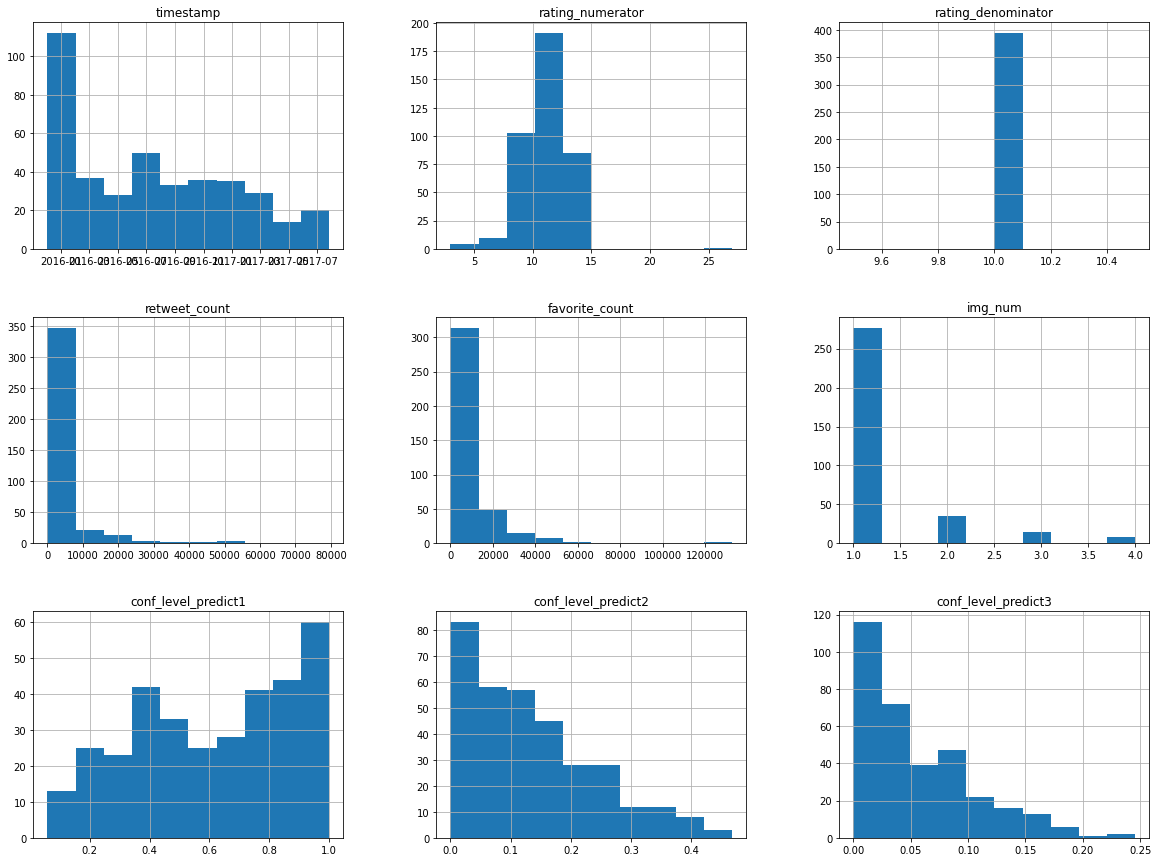

In [53]:
df_archive_clean.hist(figsize=(20,15))

Text(0.5, 1.0, 'Plot of Frequency of Occurrence of Different Ratings')

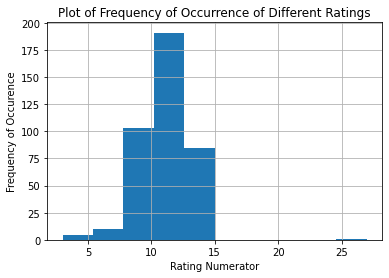

In [60]:
df_archive_clean['rating_numerator'].hist()
plt.xlabel('Rating Numerator')
plt.ylabel('Frequency of Occurence')
plt.title('Plot of Frequency of Occurrence of Different Ratings')

Text(0.5, 1.0, 'Plot of Frequency of Occurrence of Different Rating Denominators')

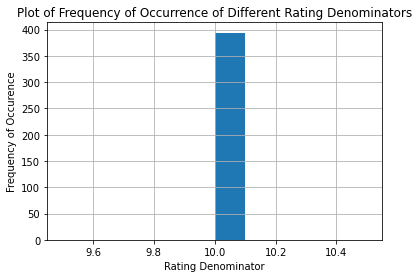

In [63]:
df_archive_clean['rating_denominator'].hist()
plt.xlabel('Rating Denominator')
plt.ylabel('Frequency of Occurence')
plt.title('Plot of Frequency of Occurrence of Different Rating Denominators')

Text(0.5, 1.0, 'Plot of Confidence Level for Second Image Prediction VS Frequency')

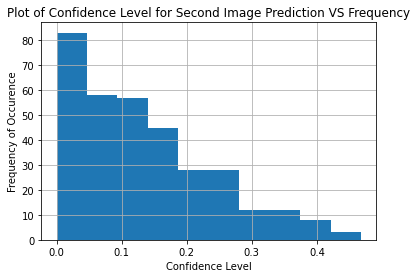

In [61]:
df_archive_clean['conf_level_predict2'].hist()
plt.xlabel('Confidence Level')
plt.ylabel('Frequency of Occurence')
plt.title('Plot of Confidence Level for Second Image Prediction VS Frequency')

Text(0.5, 1.0, 'Plot of Confidence Level for First Image Prediction VS Frequency')

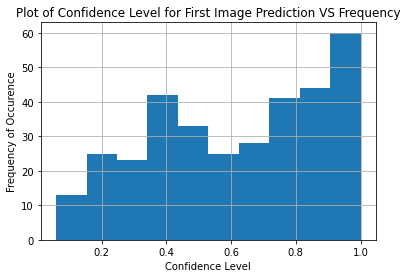

In [62]:
df_archive_clean['conf_level_predict1'].hist()
plt.xlabel('Confidence Level')
plt.ylabel('Frequency of Occurence')
plt.title('Plot of Confidence Level for First Image Prediction VS Frequency')

<Figure size 1440x1440 with 0 Axes>

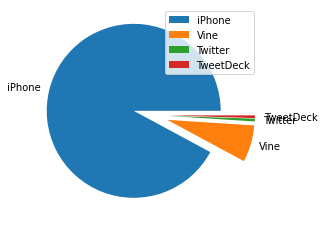

<Figure size 1440x1440 with 0 Axes>

In [54]:
mylabels = ['iPhone','Vine','Twitter','TweetDeck']
plt.pie(df_archive_clean.source.value_counts(), labels=mylabels,explode = [0.2, 0.2, 0.2, 0.2])
plt.legend()
plt.figure(figsize=[20,20])

<AxesSubplot:title={'center':'Plot of Favorite Count VS Retweet Count'}, xlabel='retweet_count', ylabel='favorite_count'>

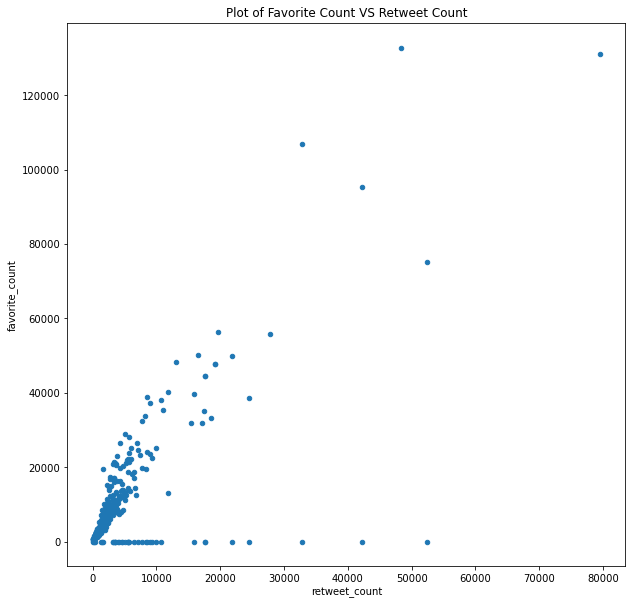

In [65]:
df_archive_clean.plot(x='retweet_count',y='favorite_count', kind = 'scatter', title = 'Plot of Favorite Count VS Retweet Count',figsize = (10,10))


### Insights:
1. Most of the images used in the dataset are sourced using an iPhone version of the Twitter app

2. There is a positive correlation between the retweet count and the favorite count

3. The confidence levels for the second and third predictions of the images using the neural networks are skewed towards the right

### Visualization

In [ ]:
df_archive_clean.plot(x='retweet_count',y='favorite_count', kind = 'scatter', figsize = (10,10))